# 1. Download and import libraries

In [ ]:
!pip install scanpy dask louvain leidenalg

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import urllib 
import os
import louvain
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Obtain the scRNA-seq data (GSM3215435)

In [ ]:
!mkdir -p data

!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_barcodes.tsv.gz
!mv GSM3215435_ldlr_ko_barcodes.tsv.gz data/barcodes.tsv.gz
!gunzip data/barcodes.tsv.gz

!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_genes.tsv.gz
!mv GSM3215435_ldlr_ko_genes.tsv.gz data/genes.tsv.gz
!gunzip data/genes.tsv.gz

!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_matrix.mtx.gz
!mv GSM3215435_ldlr_ko_matrix.mtx.gz data/matrix.mtx.gz
!gunzip data/matrix.mtx.gz

In [5]:
adata = sc.read_10x_mtx('data', var_names='gene_symbols', cache=True)
adata

AnnData object with n_obs × n_vars = 3781 × 27998
    var: 'gene_ids'

# 3. Filter out bad genes and cells

In [6]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3781 × 13105
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt'].value_counts()

False    13092
True        13
Name: mt, dtype: int64

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

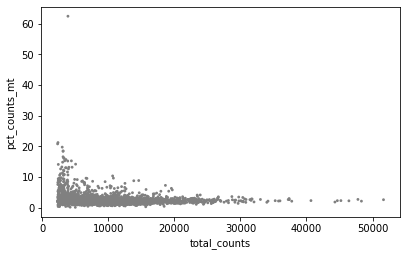

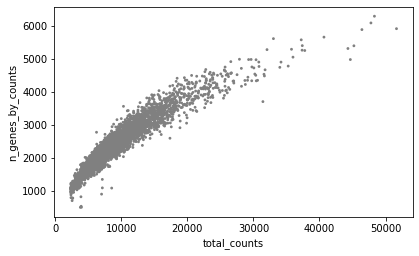

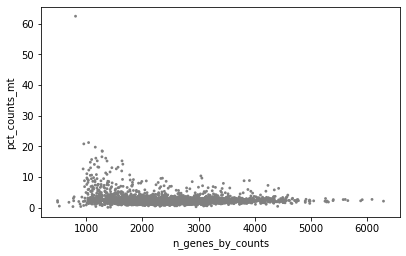

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

In [10]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

adata

AnnData object with n_obs × n_vars = 3600 × 13105
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# 4. Data normalization

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization

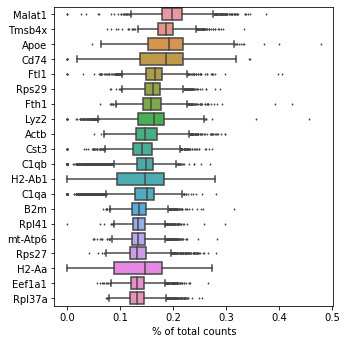

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 5. Get highly variable genes

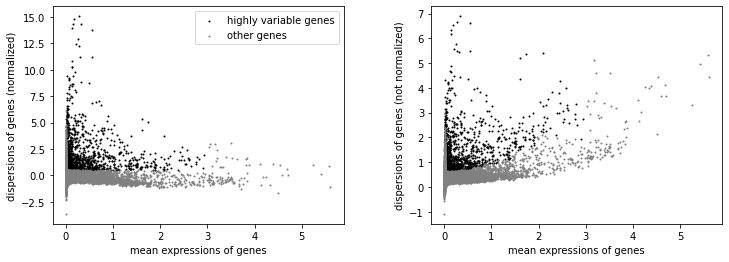

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False) # can not scale only x

In [14]:
adata.var['highly_variable'].value_counts()

False    11878
True      1227
Name: highly_variable, dtype: int64

# 6. Perform PCA

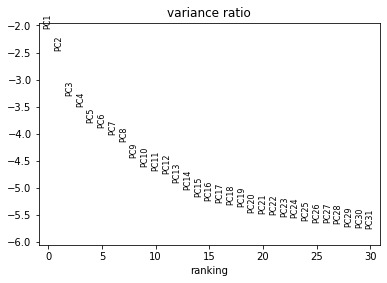

In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

# 7. Get a 2D visualization with UMAP 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


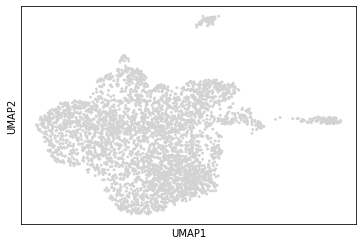

In [16]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# 8. Get clusters

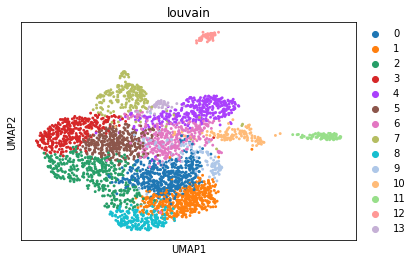

In [17]:
sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

# 9. Check for some of the known markers

Now let's see whether known markers are clustered together, like in the referenced paper.

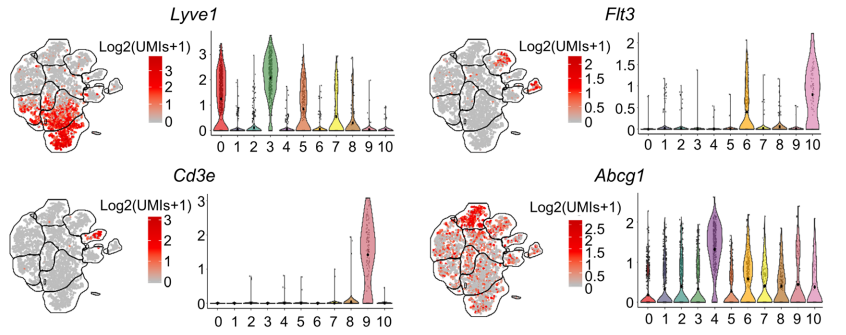

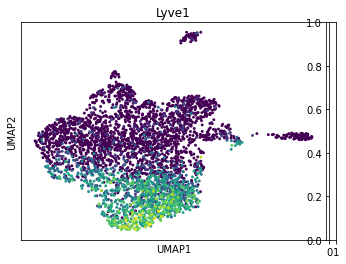

In [19]:
try:
    sc.pl.umap(adata, color=["Lyve1"])
except Exception:
    pass

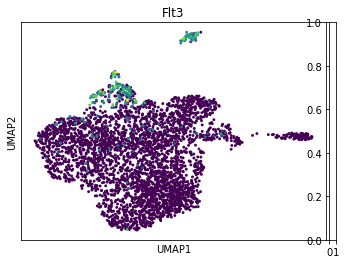

In [18]:
try:
    sc.pl.umap(adata, color=["Flt3"])
except Exception:
    pass

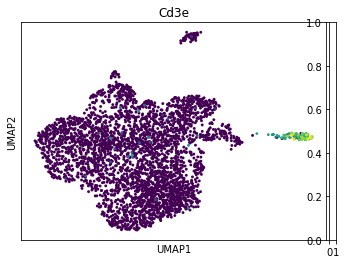

In [22]:
try:
    sc.pl.umap(adata, color=["Cd3e"])
except Exception:
    pass

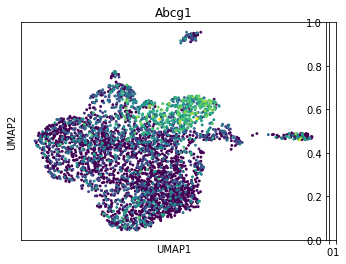

In [20]:
try:
    sc.pl.umap(adata, color=["Abcg1"])
except Exception:
    pass

As we can see, markers do indeed group together.

# 10. Find differential genes that are the most specific for each cluster

In [21]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Hspa1a,Pf4,Ccl8,Ifrd1,Lgals3,Atf3,Ccr2,Napsa,Folr2,Zbp1,Stmn1,Cd3g,Cd24a,Plac8
1,Txnip,Cbr2,Ier3,Cd83,Ctsz,Ccl4,Cx3cr1,Ifi30,Ccl6,Fcgr1,Hmgb2,Rpl13a,Naaa,Tmsb10
2,Hspa1b,Maf,Ccl7,Cd14,Ctsb,Ubc,Ctss,S100a11,Lyve1,Irf7,Tubb5,Rps15a,Cst3,Msrb1
3,Serinc3,Stab1,Ccl2,Nlrp3,Ctsd,Nfkbia,Psap,S100a4,F13a1,Mnda,Top2a,AW112010,Tmsb10,H3f3a
4,Pf4,Folr2,Ccl6,Il1b,Mpeg1,Nfkbiz,Mpeg1,Syngr2,Fxyd2,Stat1,Ptma,Cd3d,Ppt1,Napsa


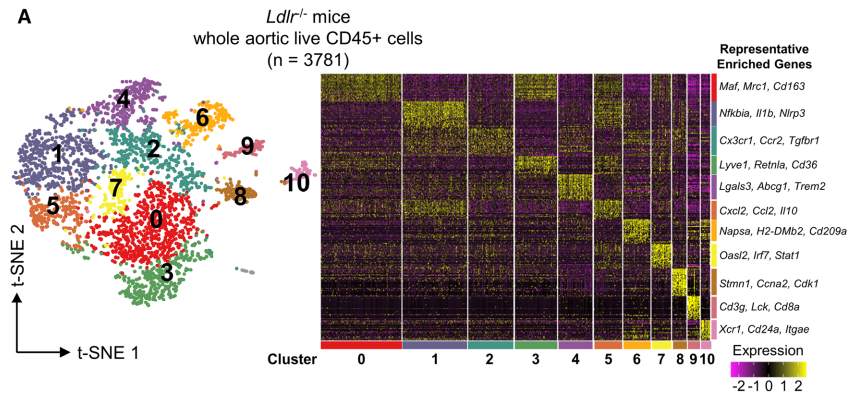

As we can see, the most enriched genes for each clusters are very similar with the ones obtained in the referenced paper.

Clusters in paper correspond to my clusters then as written below:

Their cluster - my cluster (common enriched gene)

- 0 - 1 (Maf)
- 1 - 5 (Nfkbia)
- 2 - 6 (Ccr2)
- 3 - 8 (Lyve1)
- 4 - 4 (Lgals3)
- 5 - 2 (Ccl2)
- 6 - 7 (Napsa)
- 7 - 9 (Irf7)
- 8 - 10 (Stmn1)
- 9 - 11 (Cd3g)
- 10 - 12 (Cd24a)

However, I have some clusters left - 0, 3, 13.

My cluster 3 has common top enriched genes with cluster 1 from the paper, 13 - with 6.

0-th cluster is quite small and is located between two other clusters - it is probably a statistical artifact that it clustered separately from them (or maybe it is correct and the paper is wrong.)




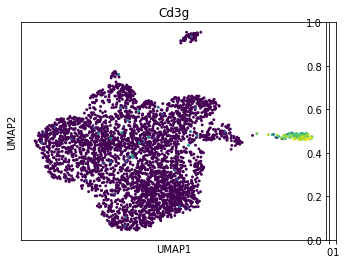

In [ ]:
try:
    sc.pl.umap(adata, color=["Cd3g"])
except Exception:
    pass

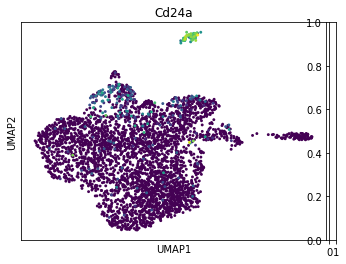

In [ ]:
try:
    sc.pl.umap(adata, color=["Cd24a"])
except Exception:
    pass

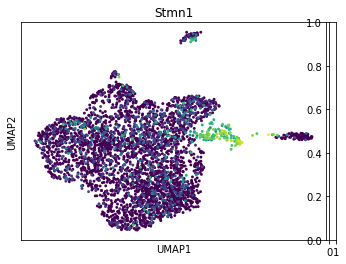

In [ ]:
try:
    sc.pl.umap(adata, color=["Stmn1"])
except Exception:
    pass

# 11. Trajectory inference

In [23]:
sc.tl.paga(adata, groups='louvain')

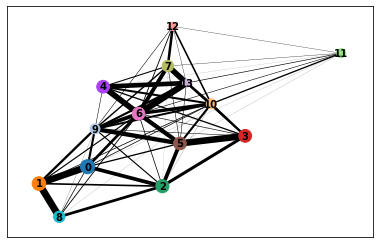

In [24]:
sc.pl.paga(adata, color=['louvain'])